<a href="https://colab.research.google.com/github/TakahashixD/ClfEnglishHandwrittenChar/blob/main/CEHC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
pd.set_option('display.max_columns', None)

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.feature import canny, hog
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import threshold_otsu
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.patches as mpatches


import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import datasets, svm, metrics
from sklearn.neighbors import KNeighborsClassifier

import pickle

from scipy import ndimage as ndi

from tabulate import tabulate

In [ ]:
#https://scholar.google.com.br/scholar?q=Efficient+Handwritten+Digit+Recognition+based+on++Histogram+of+Oriented+Gradients+and+SVM&hl=pt-BR&as_sdt=0&as_vis=1&oi=scholart
#https://peerj.com/articles/453/?report=reader&utm_source=TrendMD&utm_campaign=PeerJ_TrendMD_1&utm_medium=TrendMD
#https://research.ijcaonline.org/volume84/number2/pxc3892644.pdf
#https://www.ijert.org/research/handwritten-character-classification-and-recognition-using-neural-network-IJERTCONV3IS12020.pdf


In [ ]:
url = 'https://drive.google.com/file/d/1mmVufOw2dTwTXZk9oI6Nq_IP4Qkez6Sw/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

In [ ]:
classes = df['label'].unique()
quantity = len(df['label'].unique())
print(f'\n The %d Classes are: \n {classes}' %quantity)    




 The 62 Classes are: 
 ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
#tranformar Labels em números
LE = LabelEncoder()
df['label'] = LE.fit_transform(df['label'])
#LE.inverse_transform(df['label'])

In [ ]:
image = imread("/content/drive/MyDrive/handwriting_classf/" + df.at[3, "image"], as_gray=True)
print(image.shape)


(900, 1200)


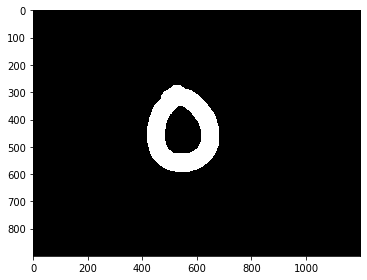

In [ ]:
thresh = threshold_otsu(image)
binary = image <= thresh
imshow(binary)

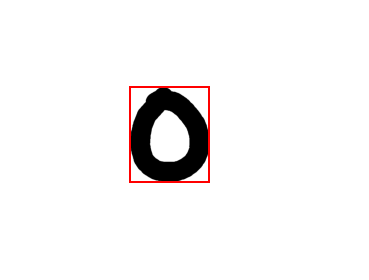

In [ ]:
fig, ax5 = plt.subplots(ncols=1, nrows=1,
                         figsize=(8, 4))

# Label image regions.

label_image = label(binary)

ax5.imshow(image, cmap=plt.cm.gray)
ax5.set_title('', fontsize=24)
ax5.axis('off')

for region in regionprops(label_image):
    # Draw rectangle around segmented coins.
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr),
                              maxc - minc,
                              maxr - minr,
                              fill=False,
                              edgecolor='red',
                              linewidth=2)
    ax5.add_patch(rect)
    cropped = binary[region.bbox[0]:region.bbox[2],region.bbox[1]:region.bbox[3]]

plt.tight_layout()
plt.show()

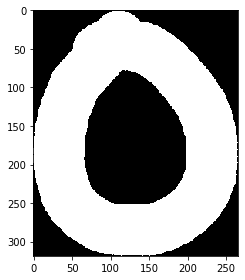

In [ ]:
imshow(cropped, cmap='gray')

(28, 28)


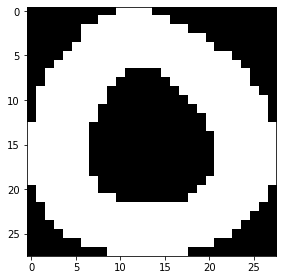

In [ ]:
resized_img = resize(cropped, (28, 28), anti_aliasing=False)
print(resized_img.shape)
imshow(resized_img, cmap='gray')

In [ ]:
resized_img

In [ ]:
lista=  []
lista.append(resized_img)


In [ ]:
hog_features, hog_img = hog(resized_img,  orientations=9, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualize=True)

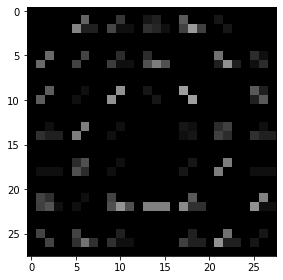

In [ ]:
imshow(hog_img, cmap='gray')

In [ ]:

# carregar as imagens pré-carregadas do arquivo de cache
try:
  with open('/content/drive/MyDrive/handwriting_classf/features_cache.pkl', 'rb') as f:
    X = pickle.load(f)
  with open('/content/drive/MyDrive/handwriting_classf/features_cache_s.pkl', 'rb') as v:
    X_bin = pickle.load(v)
  with open('/content/drive/MyDrive/handwriting_classf/imagens_cache.pkl', 'rb') as i:
    X_images = pickle.load(i)
except FileNotFoundError:
    # se o arquivo de cache não existir, carregar as imagens normalmente e salvar em cache
    images = []
    features = []
    for i in range(len(df)):
      image = imread("/content/drive/MyDrive/handwriting_classf/" + df.at[i, "image"], as_gray=True)
      thresh = threshold_otsu(image)
      binary = image <= thresh
      label_image = label(binary)
      #corta imagem
      for region in regionprops(label_image):
        cropped = binary[region.bbox[0]:region.bbox[2],region.bbox[1]:region.bbox[3]]
      #diminui imagem
      resized_img = resize(cropped, (28, 28), anti_aliasing=False)
      #hog features
      hog_features = hog(resized_img,  orientations=9, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1))
      images.append(resized_img)
      #features = np.reshape(resized_img, (100*100))
      features.append(hog_features)
    
     #salvar as imagens pré-carregadas em um arquivo de cache
    with open('features_cache_s.pkl', 'wb') as f:
        pickle.dump(features, f)
    with open('imagens_cache.pkl', 'wb') as i:
        pickle.dump(images, i)

In [ ]:
X_matrix = np.array(X)
X_matrix_bin = np.array(X_bin)

In [ ]:
imshow(X_images[0])


In [ ]:
list_of_features = []
for i in range(len(X_images)):
  img_features = np.reshape(X_images[i], (28*28))
  list_of_features.append(img_features)

In [ ]:
X_matrix_bin.shape

(3410, 441)

In [ ]:
y = df["label"]
y

0        0
1        0
2        0
3        0
4        0
        ..
3405    61
3406    61
3407    61
3408    61
3409    61
Name: label, Length: 3410, dtype: int64

In [ ]:
model = svm.SVC(kernel='rbf')
#divisão 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X_matrix_bin, y, test_size=0.3, random_state=0,  stratify=y)
print(X_train.shape) 
print(X_test.shape)
print(y_train.shape) 
print(y_test.shape)

(2387, 441)
(1023, 441)
(2387,)
(1023,)


In [ ]:
y_test.value_counts()

13    17
37    17
24    17
59    17
36    17
      ..
35    16
61    16
33    16
43    16
28    16
Name: label, Length: 62, dtype: int64

In [ ]:
model.fit(X_train, y_train)

SVC()

In [ ]:
#parametros SVM
SVM_params = [{"kernel":"rbf"}, {"kernel":"poly"}, {"kernel":"sigmoid"}, {"kernel":"linear"}]
#parametros KNN
KNN_params = kneighbors_params = [{"n_neighbors":3}, {"n_neighbors":5}, {"n_neighbors":7}, {"n_neighbors":9}]
models = [
    ['SVM', svm.SVC, SVM_params],
    ['KNN', KNeighborsClassifier, kneighbors_params]
]
#KFold
cv = StratifiedKFold(n_splits=5)
#ver número de divisões por default K = 5
cv.get_n_splits(X_matrix)


5

In [ ]:
def gerarResultados(Xtrain, Xtest, ytrain, ytest):
  resultados = []
  for modelname, Model, params_list in models:
      for params in params_list:
          model = Model(**params)
          model.fit(Xtrain, ytrain)
          predict = model.predict(Xtest)
          accuracy = "{0:.3f}".format(metrics.accuracy_score(ytest, predict))
          recall = "{0:.3f}".format(metrics.recall_score(ytest, predict, average = 'micro'))
          precision = "{0:.3f}".format(metrics.precision_score(ytest, predict, average = 'micro'))      
          resultados.append((modelname, params, accuracy, recall, precision))
  print((tabulate(resultados, headers=["Modelo", "parametros", "acurácia", "revocação", "precisão"])))

In [ ]:
gerarResultados(X_train, X_test, y_train, y_test)

Modelo    parametros               acurácia    revocação    precisão
--------  ---------------------  ----------  -----------  ----------
SVM       {'kernel': 'rbf'}           0.812        0.812       0.812
SVM       {'kernel': 'poly'}          0.79         0.79        0.79
SVM       {'kernel': 'sigmoid'}       0.791        0.791       0.791
SVM       {'kernel': 'linear'}        0.781        0.781       0.781
KNN       {'n_neighbors': 3}          0.725        0.725       0.725
KNN       {'n_neighbors': 5}          0.736        0.736       0.736
KNN       {'n_neighbors': 7}          0.741        0.741       0.741
KNN       {'n_neighbors': 9}          0.728        0.728       0.728


In [ ]:
def gerarResultadosCross(X, y):
  resultados = []
  for modelname, Model, params_list in models:
      for params in params_list:
          model = Model(**params)
          accuracy = "{0:.3f}".format(cross_val_score(model, X, y, scoring='accuracy', cv=cv).mean())
          recall = "{0:.3f}".format(cross_val_score(model, X, y, scoring='recall_micro', cv=cv).mean())
          precision = "{0:.3f}".format(cross_val_score(model, X, y, scoring='precision_micro', cv=cv).mean())
          resultados.append((modelname, params, accuracy, recall, precision))      
  print((tabulate(resultados, headers=["Modelo", "parametros", "acurácia", "revocação", "precisão"])))

In [ ]:
gerarResultadosCross(X_matrix_bin, y)

Modelo    parametros               acurácia    revocação    precisão
--------  ---------------------  ----------  -----------  ----------
SVM       {'kernel': 'rbf'}           0.801        0.801       0.801
SVM       {'kernel': 'poly'}          0.78         0.78        0.78
SVM       {'kernel': 'sigmoid'}       0.785        0.785       0.785
SVM       {'kernel': 'linear'}        0.772        0.772       0.772
KNN       {'n_neighbors': 3}          0.73         0.73        0.73
KNN       {'n_neighbors': 5}          0.73         0.73        0.73
KNN       {'n_neighbors': 7}          0.731        0.731       0.731
KNN       {'n_neighbors': 9}          0.733        0.733       0.733


In [ ]:
prediction = model.predict(X_test)

In [ ]:
y_char = LE.inverse_transform(y_test)
print(
    f"Classification report for classifier {model}:\n"
    f"{metrics.classification_report(y_char, LE.inverse_transform(prediction))}\n"
)

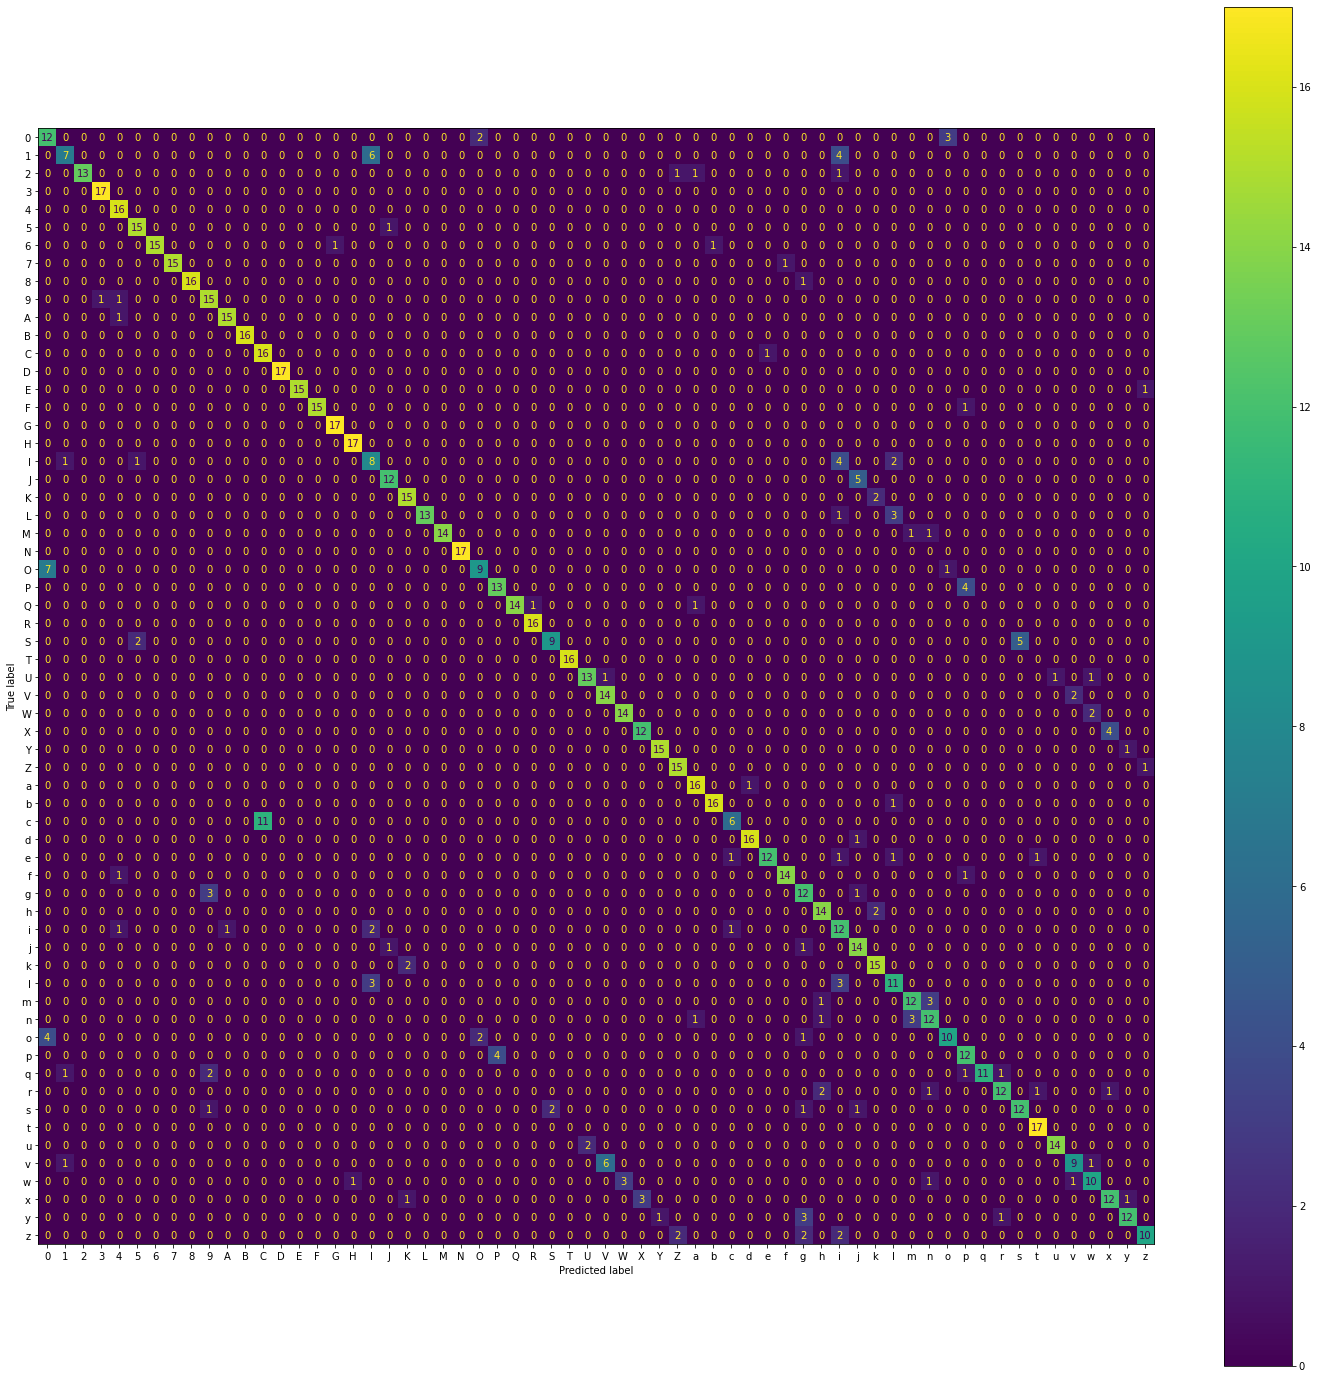

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_char, LE.inverse_transform(prediction))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=LE.inverse_transform(model.classes_))
fig, ax = plt.subplots(figsize=(25,25))
disp.plot(ax=ax)